## GAN for MNIST

Reference
- https://github.com/goodfeli/adversarial
- https://github.com/ckmarkoh/GAN-tensorflow/blob/master/gan.py
- http://www.kdnuggets.com/2016/07/mnist-generative-adversarial-model-keras.html

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

### Data loading

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
dim_image = 784

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Data visualiation

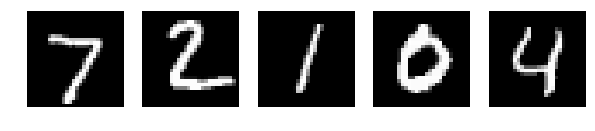

In [3]:
plt.rcParams['figure.figsize'] = (10, 2)
fig, ax_list = plt.subplots(1, 5)
for i in range(5):
    image = mnist.test.images[i].reshape((28, 28))
    label = np.argmax(mnist.test.labels[i])
    ax_list[i].axis('off')
    ax_list[i].imshow(image, cmap='gray')
plt.show()

### GAN

In [4]:
class GAN:
    def __init__(self, dim_z, dim_g_h1, dim_g_h2, dim_x, dim_d_h1, dim_d_h2):
        self.dim_z    = dim_z
        self.dim_g_h1 = dim_g_h1
        self.dim_g_h2 = dim_g_h2
        self.dim_x    = dim_x
        self.dim_d_h1 = dim_d_h1
        self.dim_d_h2 = dim_d_h2
        
        with tf.device('/gpu:0'):
        
            # Placeholders
            self.x = tf.placeholder(tf.float32, [None, self.dim_x])
            self.z = tf.placeholder(tf.float32, [None, self.dim_z])
            self.lr = tf.placeholder(tf.float32) # Learning rate
            self.dr = tf.placeholder(tf.float32) # Dropout rate

            # Generator
            G_init = tf.truncated_normal_initializer(stddev=0.1)
            with tf.variable_scope('G'):
                G_h1    = tf.layers.dense(self.z, self.dim_g_h1,
                                          activation=tf.nn.relu, kernel_initializer=G_init)

                G_h2    = tf.layers.dense(G_h1,   self.dim_g_h2,
                                          activation=tf.nn.relu, kernel_initializer=G_init)

                self.G  = tf.layers.dense(G_h2,   self.dim_x,
                                          activation=tf.tanh,    kernel_initializer=G_init)

            # Discriminator
            D_init = tf.truncated_normal_initializer(stddev=0.1)
            with tf.variable_scope('D') as scope:
                def discriminator(inputs):
                    D_h1 = tf.layers.dense(inputs, self.dim_d_h1, activation=tf.nn.relu,
                                           kernel_initializer=D_init, name='D_h1')
                    D_h1 = tf.nn.dropout(D_h1, 1 - self.dr, name='D_h1_dropout')

                    D_h2 = tf.layers.dense(D_h1,   self.dim_d_h2, activation=tf.nn.relu,
                                           kernel_initializer=D_init, name='D_h2')
                    D_h2 = tf.nn.dropout(D_h2, 1 - self.dr, name='D_h2_dropout')

                    D    = tf.layers.dense(D_h2,   1, activation=tf.sigmoid,
                                           kernel_initializer=D_init, name='D')
                    
                    return D

                self.D_real = discriminator(self.x)
                scope.reuse_variables()
                self.D_fake = discriminator(self.G)

            # Losses
            self.loss_G      = tf.reduce_mean(-tf.log(tf.clip_by_value(self.D_fake, 1e-10, 1.0)))
            self.loss_D_real = tf.reduce_mean(-tf.log(tf.clip_by_value(self.D_real, 1e-10, 1.0)))
            self.loss_D_fake = tf.reduce_mean(-tf.log(tf.clip_by_value(1 - self.D_fake, 1e-10, 1.0)))
            self.loss_D      = tf.reduce_sum((self.loss_D_real, self.loss_D_fake))

            # Optmizers
            def optimizer(loss, var_list):
                return tf.train.AdamOptimizer(self.lr).minimize(loss, var_list=var_list)
            g_params = [v for v in tf.trainable_variables() if v.name.startswith('G/')]
            d_params = [v for v in tf.trainable_variables() if v.name.startswith('D/')]
            self.op_G = optimizer(self.loss_G, g_params)
            self.op_D = optimizer(self.loss_D, d_params)
        
    def generate_noise(self, cnt):
#         return np.random.normal(0, 1, size=[cnt, self.dim_z])
        return np.random.uniform(-1, 1, size=[cnt, self.dim_z])
    
    def train_G(self, sess, batch_size, lr, dr=0):
        noise = self.generate_noise(batch_size)
        sess.run(self.op_G, feed_dict={self.z: noise, self.lr: lr, self.dr: dr})
            
    def train_D(self, sess, x, lr, dr=0):
        noise = self.generate_noise(x.shape[0])
        sess.run(self.op_D, feed_dict={self.x: x, self.z: noise, self.lr: lr, self.dr: dr})
        
    def loss(self, sess, x):
        noise       = self.generate_noise(x.shape[0])
        loss_G      = sess.run(self.loss_G, feed_dict={           self.z: noise, self.dr: 0})
        loss_D      = sess.run(self.loss_D, feed_dict={self.x: x, self.z: noise, self.dr: 0})
        loss_D_real = sess.run(self.loss_D_real, feed_dict={self.x: x, self.z: noise, self.dr: 0})
        loss_D_fake = sess.run(self.loss_D_fake, feed_dict={self.x: x, self.z: noise, self.dr: 0})
        
        return loss_G, loss_D, loss_D_real, loss_D_fake
    
    def generate_data_with_random_noise(self, sess, cnt):
        noise = self.generate_noise(cnt)
        return self.generate_data(sess, noise)
    
    def generate_data(self, sess, noise):
        return sess.run(self.G, feed_dict={self.z: noise})

In [5]:
def plot_data(x_fake, frame_str, path=None):
    # Start plot
    plt.ioff()
    plt.rcParams['figure.figsize'] = (8, 8)
    fig, ax_list = plt.subplots(NUM_IMG_TILE_CNT, NUM_IMG_TILE_CNT)
    plt.suptitle('GAN for MNIST (%s frame)'%(frame_str), fontsize=15, family='monospace')
    plt.subplots_adjust(wspace=0.075, hspace=0.075)
    
    # Draw the images
    for row_i in range(NUM_IMG_TILE_CNT):
        for col_i in range(NUM_IMG_TILE_CNT):
            image = -1.0 * x_fake[row_i * NUM_IMG_TILE_CNT + col_i].reshape((28, 28))
            ax_list[row_i][col_i].axis('off')
            ax_list[row_i][col_i].imshow(image, cmap='gray')
    
    # Finish the work
    path == None and plt.show() or plt.savefig(path, bbox_inches='tight', facecolor='white')
    plt.close()

iter=10000 | loss_G=2.3102 | loss_D=17.5934 | loss_D_real=17.4477 | loss_D_fake=0.1457
iter=20000 | loss_G=2.3437 | loss_D=18.6739 | loss_D_real=18.5449 | loss_D_fake=0.1291
iter=30000 | loss_G=1.8274 | loss_D=18.7900 | loss_D_real=18.5784 | loss_D_fake=0.2116
iter=40000 | loss_G=1.6927 | loss_D=16.7539 | loss_D_real=16.5203 | loss_D_fake=0.2335
iter=50000 | loss_G=1.7181 | loss_D=19.0413 | loss_D_real=18.8112 | loss_D_fake=0.2301
iter=60000 | loss_G=1.6444 | loss_D=20.1876 | loss_D_real=19.9467 | loss_D_fake=0.2409
iter=70000 | loss_G=1.4876 | loss_D=22.0812 | loss_D_real=21.7967 | loss_D_fake=0.2845
iter=80000 | loss_G=1.5352 | loss_D=20.4335 | loss_D_real=20.1665 | loss_D_fake=0.2670
iter=90000 | loss_G=1.3246 | loss_D=19.4007 | loss_D_real=19.0654 | loss_D_fake=0.3353
iter=100000 | loss_G=1.1815 | loss_D=20.9152 | loss_D_real=20.5223 | loss_D_fake=0.3929
iter=110000 | loss_G=1.3599 | loss_D=20.5509 | loss_D_real=20.2291 | loss_D_fake=0.3219
iter=120000 | loss_G=1.2974 | loss_D=18.5

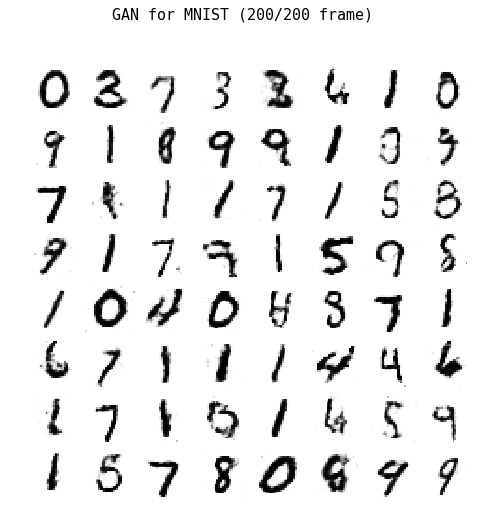

In [6]:
def sigmoid_to_tanh(x):
    return 2 * x - 1

tf.reset_default_graph()

DR = 0.5
LR = 0.0001
NUM_ITER = 2 * (10 ** 6) + 1
PRINT_STEP = 10 ** 4
NUM_FRAME = int(NUM_ITER / PRINT_STEP)
BATCH_SIZE = 2 ** 5
NUM_ITER_PT = int(NUM_ITER / 100)
NUM_IMG_TILE_CNT = 8
NUM_IMG_PLOT = NUM_IMG_TILE_CNT ** 2

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    gan = GAN(dim_z=100, dim_g_h1=250, dim_g_h2=500, dim_x=dim_image, dim_d_h1=500, dim_d_h2=250)
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    fixed_noise = gan.generate_noise(NUM_IMG_PLOT)
    
    # Draw first frame of the animation
    x_fake = gan.generate_data(sess, fixed_noise)
    plot_data(x_fake, '%3d/%d'%(0, NUM_FRAME), 'plot_gan_mnist_gpu1/%d.png'%0)
    
    # Pre-train D
    for d_iter in range(NUM_ITER_PT):
        if random.randint(1, 13) <= 11:
            x_batch, _ = mnist.train.next_batch(BATCH_SIZE)
        else:
            x_batch, _ = mnist.test.next_batch(BATCH_SIZE)
        x_batch = sigmoid_to_tanh(x_batch)
        gan.train_D(sess, x_batch, LR, DR)
    
    num_img = 0
    for iter in xrange(NUM_ITER):
        lr = LR
        
        # Train D
        for d_iter in range(4):
            if random.randint(1, 13) <= 11:
                x_batch, _ = mnist.train.next_batch(BATCH_SIZE)
            else:
                x_batch, _ = mnist.test.next_batch(BATCH_SIZE)
            x_batch = sigmoid_to_tanh(x_batch)
            gan.train_D(sess, x_batch, lr, DR)
            
        # Train G
        gan.train_G(sess, BATCH_SIZE, lr, DR)
            
        # Draw a frame of the animation
        if iter > 0 and iter % PRINT_STEP == 0:
            x_batch, _ = mnist.train.next_batch(1000)
            loss_G, loss_D, loss_D_real, loss_D_fake = gan.loss(sess, x_batch)
            print 'iter=%d | loss_G=%.4f | loss_D=%.4f | loss_D_real=%.4f | loss_D_fake=%.4f'\
                %(iter, loss_G, loss_D, loss_D_real, loss_D_fake)
            num_img += 1
            x_fake = gan.generate_data(sess, fixed_noise)
            plot_data(x_fake, '%3d/%d'%(num_img, NUM_FRAME), 'plot_gan_mnist_gpu1/%d.png'%num_img)
            
        # Plot the result
        if iter == (NUM_ITER-1):
            plot_data(x_fake, '%3d/%d'%(NUM_FRAME, NUM_FRAME))